1) Installing Kaggle and downloading the data set

In [ ]:
#cell 1
#installing kaggle and dowloading the data set
import os
from google.colab import userdata

# Get kaggle.json from Colab Secrets
kaggle_json = userdata.get("KAGGLE_JSON")

os.makedirs("/root/.kaggle", exist_ok=True)
with open("/root/.kaggle/kaggle.json", "w") as f:
    f.write(kaggle_json)

!chmod 600 /root/.kaggle/kaggle.json
!pip -q install kaggle

# download the dataset
!kaggle datasets download -d naserabdullahalam/phishing-email-dataset
!unzip -o phishing-email-dataset.zip -d data


Dataset URL: https://www.kaggle.com/datasets/naserabdullahalam/phishing-email-dataset
License(s): CC-BY-SA-4.0
  0% 0.00/77.1M [00:00<?, ?B/s]
100% 77.1M/77.1M [00:00<00:00, 857MB/s]
Archive:  phishing-email-dataset.zip
  inflating: data/CEAS_08.csv        
  inflating: data/Enron.csv          
  inflating: data/Ling.csv           
  inflating: data/Nazario.csv        
  inflating: data/Nigerian_Fraud.csv  
  inflating: data/SpamAssasin.csv    
  inflating: data/phishing_email.csv  


Extra Check to view CSVs


In [ ]:
#cell 2
#viewing the data
!ls data

CEAS_08.csv  Ling.csv	  Nigerian_Fraud.csv  SpamAssasin.csv
Enron.csv    Nazario.csv  phishing_email.csv


Setting up Google Drive to save the model and preformance for after Colab Runtime disconnects

In [ ]:
# output directory
# connecting to google drive

from google.colab import drive
from pathlib import Path
import time

drive.mount("/content/drive")

RUN_ID = time.strftime("%Y%m%d-%H%M%S")
OUT_DIR = Path(f"/content/drive/MyDrive/phishing_distilbert_runs/{RUN_ID}")
OUT_DIR.mkdir(parents=True, exist_ok=True)

print("All artifacts will be saved to:", OUT_DIR)


Mounted at /content/drive
All artifacts will be saved to: /content/drive/MyDrive/phishing_distilbert_runs/20260101-222248


Load and Combine CSVs

In [ ]:
#cell 3
#preprocess data
#combline files into a single source to use all the body text

import pandas as pd

files = ["Enron.csv", "Ling.csv", "CEAS_08.csv", "Nazario.csv", "Nigerian_Fraud.csv", "SpamAssasin.csv"]

dfs = []
for f in files:
    tmp = pd.read_csv(f"/content/data/{f}", usecols=["body", "label"])
    tmp["source"] = f.replace(".csv","")   # optional, useful for analysis
    dfs.append(tmp)

df = pd.concat(dfs, ignore_index=True)

print(df.shape)
print(df["label"].value_counts())
df.head()

# 1 is phishing email
# 0 is non-phishing


(82486, 3)
label
1    42891
0    39595
Name: count, dtype: int64


,body,label,source
0,( see attached file : hplno 525 . xls )\r\n- h...,0,Enron
1,- - - - - - - - - - - - - - - - - - - - - - fo...,0,Enron
2,"estimated actuals\r\nmarch 30 , 2001\r\nno flo...",0,Enron
3,( see attached file : hplno 530 . xls )\r\n- h...,0,Enron
4,( see attached file : hplno 601 . xls )\r\n- h...,0,Enron


In [ ]:
# email body character length statistics
import numpy as np

char_lens = df["body"].astype(str).str.len()

print("=== CHARACTER LENGTH STATS ===")
print(f"Number of emails : {len(char_lens)}")
print(f"Mean chars:   {char_lens.mean():.1f}")
print(f"Median chars: {char_lens.median():.1f}")
print(f"90th pct:     {np.percentile(char_lens, 90):.1f}")
print(f"95th pct:     {np.percentile(char_lens, 95):.1f}")
print(f"99th pct:     {np.percentile(char_lens, 99):.1f}")

print("\n=== CHARACTER THRESHOLDS ===")
print(f"> 12,000 chars: {(char_lens > 12000).sum()} ({(char_lens > 12000).mean()*100:.2f}%)")
print(f"> 20,000 chars: {(char_lens > 20000).sum()} ({(char_lens > 20000).mean()*100:.2f}%)")


=== CHARACTER LENGTH STATS ===
Number of emails : 82486
Mean chars:   1760.4
Median chars: 735.0
90th pct:     3895.0
95th pct:     5133.8
99th pct:     12819.7

=== CHARACTER THRESHOLDS ===
> 12,000 chars: 918 (1.11%)
> 20,000 chars: 419 (0.51%)


Preprocessing - Clean up the body text

In [ ]:
#cell 4
import re

#clean up the text a bit

def clean_body(text):
    if not isinstance(text, str):
        return ""
    text = text.lower()
    text = re.sub(r"http\S+|www\.\S+", " <URL> ", text)
    text = re.sub(r"\b[\w\.-]+@[\w\.-]+\.\w+\b", " <EMAIL> ", text)
    text = re.sub(r"\s+", " ", text).strip()
    return text

df["body"] = df["body"].apply(clean_body)
df = df[df["body"].str.len() > 0].reset_index(drop=True)

#add a maximum character length
#20000 char is ab 3000 words, emails are usually shorter
MAX_CHARS = 20000
df["body"] = df["body"].str.slice(0, MAX_CHARS)

Training and Validation Splits

In [ ]:
# cell 5 Train / Val / Test split (80/10/10) + optional subsampling

from sklearn.model_selection import train_test_split
import numpy as np

SEED = 42
rng = np.random.default_rng(SEED)

X = df["body"].tolist()
y = df["label"].tolist()

# 1) Split off TEST first: 10%
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y,
    test_size=0.10,
    random_state=SEED,
    stratify=y
)

# 2) Split remaining 90% into TRAIN (80%) and VAL (10%)
# Since X_temp is 90% of total, val should be 10% total => val fraction within temp is 0.10/0.90 = 1/9
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp,
    test_size=(1/9),
    random_state=SEED,
    stratify=y_temp
)

print("Raw split sizes:")
print(" Train:", len(X_train), " Val:", len(X_val), " Test:", len(X_test))

def label_balance(name, labels):
    return {0: labels.count(0), 1: labels.count(1), "pos_rate": sum(labels)/len(labels)}

print("\nLabel balance:")
print(" Train:", label_balance("train", y_train))
print(" Val  :", label_balance("val", y_val))
print(" Test :", label_balance("test", y_test))


# OPTIONAL: subsample each split done for compute time
# Set these to None to use full split sizes

MAX_TRAIN_SAMPLES = 33000   # e.g. 33000, or None
MAX_VAL_SAMPLES   = 8000    # e.g. 8000,  or None
MAX_TEST_SAMPLES  = 8000    # e.g. 8000,  or None

def subsample(Xs, ys, max_n, rng):
    if (max_n is None) or (len(Xs) <= max_n):
        return Xs, ys
    idx = rng.choice(len(Xs), size=max_n, replace=False)
    Xs_sub = [Xs[i] for i in idx]
    ys_sub = [ys[i] for i in idx]
    return Xs_sub, ys_sub

X_train, y_train = subsample(X_train, y_train, MAX_TRAIN_SAMPLES, rng)
X_val,   y_val   = subsample(X_val,   y_val,   MAX_VAL_SAMPLES,   rng)
X_test,  y_test  = subsample(X_test,  y_test,  MAX_TEST_SAMPLES,  rng)

print("\nAfter optional subsampling:")
print(" Train:", len(X_train), " Val:", len(X_val), " Test:", len(X_test))
print(" Train balance:", label_balance("train", y_train))
print(" Val balance  :", label_balance("val", y_val))
print(" Test balance :", label_balance("test", y_test))


Raw split sizes:
 Train: 65984  Val: 8248  Test: 8249

Label balance:
 Train: {0: 31676, 1: 34308, 'pos_rate': 0.5199442289039767}
 Val  : {0: 3959, 1: 4289, 'pos_rate': 0.5200048496605237}
 Test : {0: 3960, 1: 4289, 'pos_rate': 0.5199418111286217}

After optional subsampling:
 Train: 33000  Val: 8000  Test: 8000
 Train balance: {0: 16015, 1: 16985, 'pos_rate': 0.5146969696969697}
 Val balance  : {0: 3847, 1: 4153, 'pos_rate': 0.519125}
 Test balance : {0: 3859, 1: 4141, 'pos_rate': 0.517625}


Getting the tokenizer

In [ ]:
#cell 6

from transformers import DistilBertTokenizerFast

print("Loading DistilBERT tokenizer...")
tokenizer = DistilBertTokenizerFast.from_pretrained("distilbert-base-uncased")


Loading DistilBERT tokenizer...


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

Calculate Median Tokens to find a good MAX_LEN

In [ ]:
#cell 7
import numpy as np, random

sample_texts = random.sample(X_train, 2000)
lengths = [len(tokenizer.encode(t, add_special_tokens=True)) for t in sample_texts]

print("Sample token lengths:")
print(" mean:", np.mean(lengths))
print(" median:", np.median(lengths))
print(" p90:", np.percentile(lengths, 90))
print(" p95:", np.percentile(lengths, 95))
print(" p99:", np.percentile(lengths, 99))
print(" max:", np.max(lengths))

# Recommend MAX_LEN from evidence


Token indices sequence length is longer than the specified maximum sequence length for this model (718 > 512). Running this sequence through the model will result in indexing errors


Sample token lengths:
 mean: 401.3135
 median: 198.0
 p90: 836.1000000000001
 p95: 1320.5499999999995
 p99: 3503.04
 max: 7831


Tokenize train, validation, and test

In [ ]:
#cell 9
MAX_LEN = 256*2  # good tradeoff for emails + GPU memory
#512 is a good choice as it is above the median estimated above


train_encodings = tokenizer(
    X_train,
    truncation=True,
    padding=True,
    max_length=MAX_LEN,
    return_tensors="pt"
)

val_encodings = tokenizer(
    X_val,
    truncation=True,
    padding=True,
    max_length=MAX_LEN,
    return_tensors="pt"
)

test_encodings = tokenizer(
    X_test,
    truncation=True,
    padding=True,
    max_length=MAX_LEN,
    return_tensors="pt"
)

Device set and Imports

Datasets and Dataloaders

In [ ]:
#cell 11

#importing and setting the device to utilize GPU
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
import numpy as np
import time

from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix, classification_report
from transformers import DistilBertForSequenceClassification, get_linear_schedule_with_warmup
from torch.optim import AdamW

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

#Datasets and Dataloaders

#Train and Validation

train_labels = torch.tensor(y_train, dtype=torch.long)
val_labels   = torch.tensor(y_val, dtype=torch.long)

train_dataset = TensorDataset(
    train_encodings["input_ids"],
    train_encodings["attention_mask"],
    train_labels
)

val_dataset = TensorDataset(
    val_encodings["input_ids"],
    val_encodings["attention_mask"],
    val_labels
)

BATCH_SIZE = 32  #small

train_loader = DataLoader(
    train_dataset,
    sampler=RandomSampler(train_dataset),
    batch_size=BATCH_SIZE
)

val_loader = DataLoader(
    val_dataset,
    sampler=SequentialSampler(val_dataset),
    batch_size=BATCH_SIZE
)

print("Train batches:", len(train_loader))
print("Val batches:", len(val_loader))


#test dataset and dataloader

test_labels = torch.tensor(y_test, dtype=torch.long)

test_dataset = TensorDataset(
    test_encodings["input_ids"],
    test_encodings["attention_mask"],
    test_labels
)

test_loader = DataLoader(
    test_dataset,
    sampler=SequentialSampler(test_dataset),
    batch_size=BATCH_SIZE
)

print("Test batches:", len(test_loader))

Device: cuda
Train batches: 1032
Val batches: 250
Test batches: 250


Model + optimizer + scheduler

In [ ]:
#cell 12

# creating the model
model = DistilBertForSequenceClassification.from_pretrained(
    "distilbert-base-uncased",
    num_labels=2
)
model.to(device)

# setting the number of epochs and learning rate
EPOCHS = 3
lr = 2e-5

#optimizer
optimizer = AdamW(model.parameters(), lr=lr)

total_steps = len(train_loader) * EPOCHS
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=int(0.1 * total_steps),
    num_training_steps=total_steps
)

print("Total training steps:", total_steps)


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Total training steps: 3096


Evaluation Function for training loop

In [ ]:
#cell 13
#definied the evaluation functions for the training loop

def format_time(seconds):
    return time.strftime("%H:%M:%S", time.gmtime(seconds))

def evaluate(model, dataloader):
    model.eval()
    all_preds = []
    all_labels = []

    total_loss = 0.0

    with torch.no_grad():
        for batch in dataloader:
            input_ids = batch[0].to(device)
            attention_mask = batch[1].to(device)
            labels = batch[2].to(device)

            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                labels=labels
            )

            loss = outputs.loss
            logits = outputs.logits

            total_loss += loss.item()

            preds = torch.argmax(logits, dim=1).detach().cpu().numpy()
            lab   = labels.detach().cpu().numpy()

            all_preds.extend(preds)
            all_labels.extend(lab)

    avg_loss = total_loss / len(dataloader)

    acc = accuracy_score(all_labels, all_preds)
    prec, rec, f1, _ = precision_recall_fscore_support(
        all_labels, all_preds, average="binary", pos_label=1, zero_division=0
    )

    return avg_loss, acc, prec, rec, f1, np.array(all_labels), np.array(all_preds)

Training loop with early stopping and saving best epoch

In [ ]:
# cell 14

import pandas as pd
from pathlib import Path

torch.manual_seed(42)
np.random.seed(42)

# for early stopping
best_f1 = -1.0
PATIENCE = 1
MIN_DELTA = 0.001
patience_counter = 0

# for saving the best epoch model
SAVE_DIR = OUT_DIR / "best_distilbert_model"
SAVE_DIR.mkdir(parents=True, exist_ok=True)

history = []  # store metrics per epoch

for epoch in range(1, EPOCHS + 1):
    print(f"\n~~~ Epoch {epoch}/{EPOCHS} ~~~")
    t0 = time.time()

    model.train()
    total_train_loss = 0.0

    for step, batch in enumerate(train_loader, start=1):
        input_ids = batch[0].to(device)
        attention_mask = batch[1].to(device)
        labels = batch[2].to(device)

        model.zero_grad()

        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            labels=labels
        )

        loss = outputs.loss
        total_train_loss += loss.item()
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        optimizer.step()
        scheduler.step()

        if step % 200 == 0:
            print(f"  Step {step}/{len(train_loader)}  |  Loss: {loss.item():.4f}")

    avg_train_loss = total_train_loss / len(train_loader)
    train_time = format_time(time.time() - t0)

    # get statistics after each epoch
    t1 = time.time()
    val_loss, val_acc, val_prec, val_rec, val_f1, y_true, y_pred = evaluate(model, val_loader)
    val_time = format_time(time.time() - t1)

    print(f"\n  Avg Train Loss: {avg_train_loss:.4f} | time {train_time}")
    print(f"  Val Loss: {val_loss:.4f} | time {val_time}")
    print(f"  Val Acc:  {val_acc:.4f}")
    print(f"  Val Prec: {val_prec:.4f} | Val Rec: {val_rec:.4f} | Val F1: {val_f1:.4f}")

    history.append({
        "epoch": epoch,
        "train_loss": avg_train_loss,
        "val_loss": val_loss,
        "val_acc": val_acc,
        "val_prec": val_prec,
        "val_rec": val_rec,
        "val_f1": val_f1,
    })

    # save the best model early stopping
    if val_f1 > best_f1 + MIN_DELTA:
        best_f1 = val_f1
        patience_counter = 0
        print(f"New best F1 — saving model to {SAVE_DIR}")
        model.save_pretrained(str(SAVE_DIR))
        tokenizer.save_pretrained(str(SAVE_DIR))
    else:
        patience_counter += 1
        print(f"No meaningful improvement. Patience {patience_counter}/{PATIENCE}")
        if patience_counter >= PATIENCE:
            print("Early stopping triggered.")
            break

# make a DataFrame for creating graphs
history_df = pd.DataFrame(history)

print("\n~~~ Averages accross all epochs ~~~")
print("Avg Val Acc :", history_df["val_acc"].mean())
print("Avg Val Prec:", history_df["val_prec"].mean())
print("Avg Val Rec :", history_df["val_rec"].mean())
print("Avg Val F1  :", history_df["val_f1"].mean())

history_df



~~~ Epoch 1/3 ~~~
  Step 200/1032  |  Loss: 0.1251
  Step 400/1032  |  Loss: 0.0809
  Step 600/1032  |  Loss: 0.0112
  Step 800/1032  |  Loss: 0.0066
  Step 1000/1032  |  Loss: 0.0716

  Avg Train Loss: 0.1348 | time 00:24:05
  Val Loss: 0.0575 | time 00:01:53
  Val Acc:  0.9825
  Val Prec: 0.9938 | Val Rec: 0.9723 | Val F1: 0.9830
New best F1 — saving model to /content/drive/MyDrive/phishing_distilbert_runs/20260101-222248/best_distilbert_model

~~~ Epoch 2/3 ~~~
  Step 200/1032  |  Loss: 0.0637
  Step 400/1032  |  Loss: 0.0022
  Step 600/1032  |  Loss: 0.0006
  Step 800/1032  |  Loss: 0.0028
  Step 1000/1032  |  Loss: 0.0005

  Avg Train Loss: 0.0233 | time 00:24:06
  Val Loss: 0.0408 | time 00:01:53
  Val Acc:  0.9895
  Val Prec: 0.9944 | Val Rec: 0.9853 | Val F1: 0.9898
New best F1 — saving model to /content/drive/MyDrive/phishing_distilbert_runs/20260101-222248/best_distilbert_model

~~~ Epoch 3/3 ~~~
  Step 200/1032  |  Loss: 0.0003
  Step 400/1032  |  Loss: 0.0087
  Step 600/10

,epoch,train_loss,val_loss,val_acc,val_prec,val_rec,val_f1
0,1,0.134805,0.057474,0.982500,0.993847,0.972309,0.982960
1,2,0.023289,0.040770,0.989500,0.994411,0.985312,0.989840
2,3,0.005404,0.040217,0.991875,0.993720,0.990609,0.992162


Final Accuracy statistics from the best epoch

In [ ]:
# cell 15

from transformers import DistilBertForSequenceClassification

model = DistilBertForSequenceClassification.from_pretrained(str(SAVE_DIR))
model.to(device)

val_loss, val_acc, val_prec, val_rec, val_f1, y_true, y_pred = evaluate(model, val_loader)

print("Final Validation Metrics")
print("Accuracy:", val_acc)
print("Precision:", val_prec)
print("Recall:", val_rec)
print("F1:", val_f1)

print("\nConfusion Matrix (rows=true, cols=pred)")
print(confusion_matrix(y_true, y_pred))

print("\nClassification Report")
print(classification_report(y_true, y_pred, digits=4))


Final Validation Metrics
Accuracy: 0.991875
Precision: 0.993719806763285
Recall: 0.9906091981699976
F1: 0.9921620643916557

Confusion Matrix (rows=true, cols=pred)
[[3821   26]
 [  39 4114]]

Classification Report
              precision    recall  f1-score   support

           0     0.9899    0.9932    0.9916      3847
           1     0.9937    0.9906    0.9922      4153

    accuracy                         0.9919      8000
   macro avg     0.9918    0.9919    0.9919      8000
weighted avg     0.9919    0.9919    0.9919      8000



Final evaluation Based on Test data set and Graphing results

~~~ Best model validation statistics ~~~
Val Loss: 0.0402
Val Acc : 0.9919
Val Prec: 0.9937
Val Rec : 0.9906
Val F1  : 0.9922

=== Best model final report on stratified test data ===
Test Loss: 0.0439
Test Acc : 0.9909
Test Prec: 0.9927
Test Rec : 0.9896
Test F1  : 0.9912

~~~ Test set confusion matrix ~~~
[[3829   30]
 [  43 4098]]

~~~ Test set classification report ~~~
              precision    recall  f1-score   support

           0     0.9889    0.9922    0.9906      3859
           1     0.9927    0.9896    0.9912      4141

    accuracy                         0.9909      8000
   macro avg     0.9908    0.9909    0.9909      8000
weighted avg     0.9909    0.9909    0.9909      8000



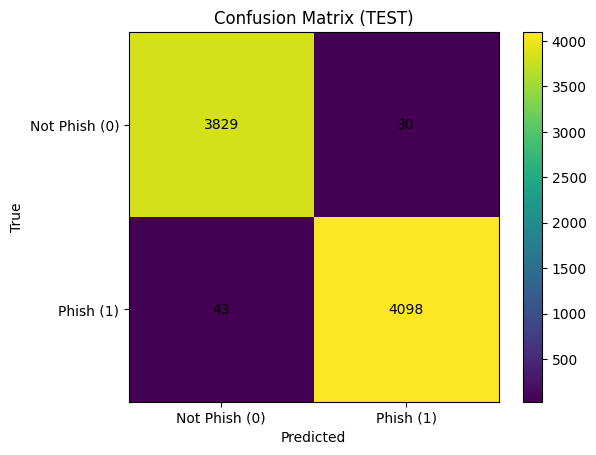

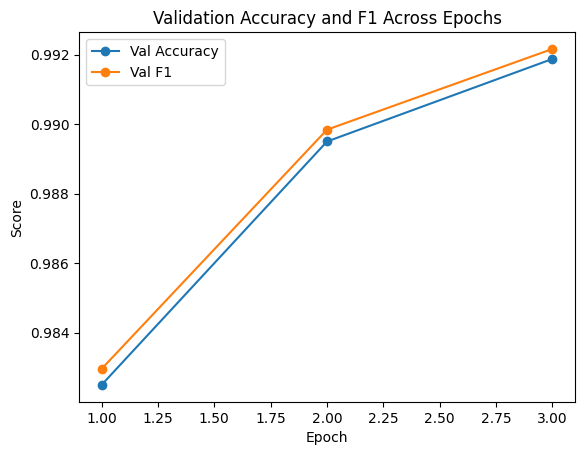

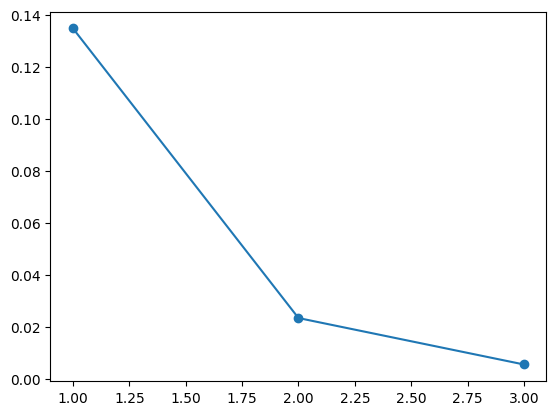

In [ ]:
# cell 16 — FIXED

import matplotlib.pyplot as plt
import numpy as np
from transformers import DistilBertForSequenceClassification
from sklearn.metrics import confusion_matrix, classification_report

# load the best model (use the actual save path)
best_model = DistilBertForSequenceClassification.from_pretrained(str(SAVE_DIR)).to(device)

# evaluate it on validation
val_loss, val_acc, val_prec, val_rec, val_f1, y_true_val, y_pred_val = evaluate(best_model, val_loader)

print("~~~ Best model validation statistics ~~~")
print(f"Val Loss: {val_loss:.4f}")
print(f"Val Acc : {val_acc:.4f}")
print(f"Val Prec: {val_prec:.4f}")
print(f"Val Rec : {val_rec:.4f}")
print(f"Val F1  : {val_f1:.4f}")

# evaluate it on testing data
test_loss, test_acc, test_prec, test_rec, test_f1, y_true_test, y_pred_test = evaluate(best_model, test_loader)

print("\n=== Best model final report on stratified test data ===")
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Acc : {test_acc:.4f}")
print(f"Test Prec: {test_prec:.4f}")
print(f"Test Rec : {test_rec:.4f}")
print(f"Test F1  : {test_f1:.4f}")

print("\n~~~ Test set confusion matrix ~~~")
cm_test = confusion_matrix(y_true_test, y_pred_test)
print(cm_test)

print("\n~~~ Test set classification report ~~~")
print(classification_report(y_true_test, y_pred_test, digits=4))

# confusion matrix plot (test)
plt.figure()
plt.imshow(cm_test)
plt.title("Confusion Matrix (TEST)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.xticks([0, 1], ["Not Phish (0)", "Phish (1)"])
plt.yticks([0, 1], ["Not Phish (0)", "Phish (1)"])

for i in range(cm_test.shape[0]):
    for j in range(cm_test.shape[1]):
        plt.text(j, i, str(cm_test[i, j]), ha="center", va="center")

plt.colorbar()
plt.show()

# graph the training curves
if "history_df" in globals():
    plt.figure()
    plt.plot(history_df["epoch"], history_df["val_acc"], marker="o")
    plt.plot(history_df["epoch"], history_df["val_f1"], marker="o")
    plt.xlabel("Epoch")
    plt.ylabel("Score")
    plt.title("Validation Accuracy and F1 Across Epochs")
    plt.legend(["Val Accuracy", "Val F1"])
    plt.show()

    plt.figure()
    plt.plot(history_df["epoch"], history_df["train_loss"], marker="o")


Saving results to Google Drive (extra step)

In [ ]:
# save artifacts to Drive so they survive when Google Colab disconnects

import pandas as pd

# saving history
history_path = OUT_DIR / "training_history.csv"
history_df.to_csv(history_path, index=False)

# save test metrics summary
summary_text = f"""DistilBERT Phishing Detection
MAX_LEN: {MAX_LEN}
BATCH_SIZE: {BATCH_SIZE}
EPOCHS: {EPOCHS}
LR: {lr}

Averages across epochs:
Avg Val Acc : {history_df["val_acc"].mean():.4f}
Avg Val Prec: {history_df["val_prec"].mean():.4f}
Avg Val Rec : {history_df["val_rec"].mean():.4f}
Avg Val F1  : {history_df["val_f1"].mean():.4f}

Final TEST:
Test Acc : {test_acc:.4f}
Test Prec: {test_prec:.4f}
Test Rec : {test_rec:.4f}
Test F1  : {test_f1:.4f}

Test Confusion Matrix:
{cm_test}
"""

results_path = OUT_DIR / "results.txt"
results_path.write_text(summary_text)

print("Saved:", history_path)
print("Saved:", results_path)
print("Saved model dir:", SAVE_DIR)


Saved: /content/drive/MyDrive/phishing_distilbert_runs/20260101-222248/training_history.csv
Saved: /content/drive/MyDrive/phishing_distilbert_runs/20260101-222248/results.txt
Saved model dir: /content/drive/MyDrive/phishing_distilbert_runs/20260101-222248/best_distilbert_model


End